In [3]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [4]:
import yfinance as yf

data = yf.download(tickers = "GLD", start="2017-12-01", end="2023-06-16", interval='1d')
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-12-01,120.940002,122.430000,120.739998,121.589996,121.589996,13080100
2017-12-04,121.150002,121.199997,120.839996,121.180000,121.180000,6943700
2017-12-05,120.099998,120.510002,119.720001,120.320000,120.320000,10041200
2017-12-06,120.040001,120.440002,119.870003,120.070000,120.070000,6643000
2017-12-07,119.010002,119.239998,118.099998,118.489998,118.489998,12900200
...,...,...,...,...,...,...
2023-06-09,182.360001,182.789993,181.720001,182.039993,182.039993,4379200
2023-06-12,181.800003,181.940002,181.039993,181.880005,181.880005,4873600
2023-06-13,182.100006,182.429993,180.169998,180.539993,180.539993,5126700


In [5]:
data = data.reset_index('Date', inplace=False)

In [6]:
# Chuyển cột 'Date' thành kiểu dữ liệu datetime
data['Date'] = pd.to_datetime(data['Date'])

# Sắp xếp dữ liệu theo thứ tự tăng dần của cột 'Date'
data.sort_values(by='Date', inplace=True)

# Chuyển cột 'Date' thành mảng numpy
dates = data['Date'].values

# Chuyển cột 'Close' thành mảng numpy
close_prices = data['Close'].values

In [7]:
# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(data))
test_size = int(0.2 * len(data))
val_size = len(data) - train_size - test_size

train_data = data[:train_size]
test_data = data[train_size:train_size+test_size]
val_data = data[train_size+test_size:]

In [8]:
train_dates = train_data['Date'].values
train_close_prices = train_data['Close'].values
val_dates = val_data['Date'].values
val_close_prices = val_data['Close'].values
test_dates = test_data['Date'].values
test_close_prices = test_data['Close'].values

In [9]:
train_dates = train_data.index.values
test_dates = test_data.index.values
val_dates = val_data.index.values

In [10]:
X_train = torch.from_numpy(train_dates.reshape(-1, 1)).float()
y_train = torch.from_numpy(train_close_prices.reshape(-1, 1)).float()
X_test = torch.from_numpy(test_dates.reshape(-1, 1)).float()
y_test = torch.from_numpy(test_close_prices.reshape(-1, 1)).float()
X_val = torch.from_numpy(val_dates.reshape(-1, 1)).float()
y_val = torch.from_numpy(val_close_prices.reshape(-1, 1)).float()

In [11]:
# Xác định kiến trúc của mạng Bayesian Neural Network
class BNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(BNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [12]:
# Xác định hàm mất mát và bộ tối ưu hóa
criterion = nn.MSELoss()
learning_rate = 0.001
num_epochs = 1000

In [13]:
# Khởi tạo mô hình BNN
model = BNN(input_size=1, output_size=1)

In [14]:
# Huấn luyện mô hình BNN
for epoch in range(num_epochs):
    model.train()

    # Tính đầu ra dự đoán của mô hình
    y_pred = model(X_train)

    # Tính lỗi dự đoán so với giá thực tế
    loss = criterion(y_pred, y_train)

    # Backpropagation và cập nhật trọng số
    loss.backward()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')


Epoch [100/1000], Loss: 8734.6962890625
Epoch [200/1000], Loss: 5186.630859375
Epoch [300/1000], Loss: 8453.2998046875
Epoch [400/1000], Loss: 8610.80859375
Epoch [500/1000], Loss: 8241.240234375
Epoch [600/1000], Loss: 3481.425048828125
Epoch [700/1000], Loss: 3010.50439453125
Epoch [800/1000], Loss: 4048.36083984375
Epoch [900/1000], Loss: 3763.9130859375
Epoch [1000/1000], Loss: 4508.08740234375


In [15]:
# Dự đoán trên tập test
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test)

In [16]:
# Dự đoán trên tập validation
model.eval()
with torch.no_grad():
    y_pred_val = model(X_val)

In [17]:
# In kết quả dự đoán trên tập test
print('Kết quả dự đoán trên tập test:')
for i in range(len(test_dates)):
    print(f'Date: {test_dates[i]}, Predicted Close: {y_pred_test[i].item()}')

Kết quả dự đoán trên tập test:
Date: 975, Predicted Close: 310.11077880859375
Date: 976, Predicted Close: 310.420166015625
Date: 977, Predicted Close: 310.72955322265625
Date: 978, Predicted Close: 311.03887939453125
Date: 979, Predicted Close: 311.3482666015625
Date: 980, Predicted Close: 311.65765380859375
Date: 981, Predicted Close: 311.9670104980469
Date: 982, Predicted Close: 312.2763977050781
Date: 983, Predicted Close: 312.5857849121094
Date: 984, Predicted Close: 312.8951721191406
Date: 985, Predicted Close: 313.2045593261719
Date: 986, Predicted Close: 313.5138854980469
Date: 987, Predicted Close: 313.82330322265625
Date: 988, Predicted Close: 314.1326599121094
Date: 989, Predicted Close: 314.4420166015625
Date: 990, Predicted Close: 314.75140380859375
Date: 991, Predicted Close: 315.0608215332031
Date: 992, Predicted Close: 315.37017822265625
Date: 993, Predicted Close: 315.67950439453125
Date: 994, Predicted Close: 315.9889221191406
Date: 995, Predicted Close: 316.2982788085

In [18]:
# In kết quả dự đoán trên tập validation
print('Kết quả dự đoán trên tập validation:')
for i in range(len(val_dates)):
    print(f'Date: {val_dates[i]}, Predicted Close: {y_pred_val[i].item()}')


Kết quả dự đoán trên tập validation:
Date: 1253, Predicted Close: 396.11712646484375
Date: 1254, Predicted Close: 396.42657470703125
Date: 1255, Predicted Close: 396.7359313964844
Date: 1256, Predicted Close: 397.0453186035156
Date: 1257, Predicted Close: 397.35467529296875
Date: 1258, Predicted Close: 397.6640930175781
Date: 1259, Predicted Close: 397.97344970703125
Date: 1260, Predicted Close: 398.2828063964844
Date: 1261, Predicted Close: 398.5921936035156
Date: 1262, Predicted Close: 398.9015808105469
Date: 1263, Predicted Close: 399.2109680175781
Date: 1264, Predicted Close: 399.52032470703125
Date: 1265, Predicted Close: 399.8297119140625
Date: 1266, Predicted Close: 400.13909912109375
Date: 1267, Predicted Close: 400.44842529296875
Date: 1268, Predicted Close: 400.7578125
Date: 1269, Predicted Close: 401.06719970703125
Date: 1270, Predicted Close: 401.3765869140625
Date: 1271, Predicted Close: 401.6859130859375
Date: 1272, Predicted Close: 401.99530029296875
Date: 1273, Predicte

In [19]:
last_index =  data.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
#x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

x_next_30_days = torch.from_numpy(np.array(range(last_index+1, last_index+31)).reshape(-1, 1)).float()
# Dự đoán giá đóng cửa cho 30 ngày tiếp theo
model.eval()
with torch.no_grad():
    y_pred_next = model(x_next_30_days)

# Chuyển đổi kết quả dự đoán thành mảng numpy
y_pred_next = y_pred_next.numpy().flatten()

# Hiển thị kết quả dự đoán
for i in range(len(x_next_30_days)):
    print(f'Date: {x_next_30_days[i]}, Predicted Close: {y_pred_next[i]}')

Date: tensor([1393.]), Predicted Close: 439.4297790527344
Date: tensor([1394.]), Predicted Close: 439.7391662597656
Date: tensor([1395.]), Predicted Close: 440.04852294921875
Date: tensor([1396.]), Predicted Close: 440.35791015625
Date: tensor([1397.]), Predicted Close: 440.6673278808594
Date: tensor([1398.]), Predicted Close: 440.9766540527344
Date: tensor([1399.]), Predicted Close: 441.2860412597656
Date: tensor([1400.]), Predicted Close: 441.595458984375
Date: tensor([1401.]), Predicted Close: 441.90478515625
Date: tensor([1402.]), Predicted Close: 442.21417236328125
Date: tensor([1403.]), Predicted Close: 442.5235290527344
Date: tensor([1404.]), Predicted Close: 442.8329162597656
Date: tensor([1405.]), Predicted Close: 443.14227294921875
Date: tensor([1406.]), Predicted Close: 443.45166015625
Date: tensor([1407.]), Predicted Close: 443.7610168457031
Date: tensor([1408.]), Predicted Close: 444.0704040527344
Date: tensor([1409.]), Predicted Close: 444.3797912597656
Date: tensor([1410

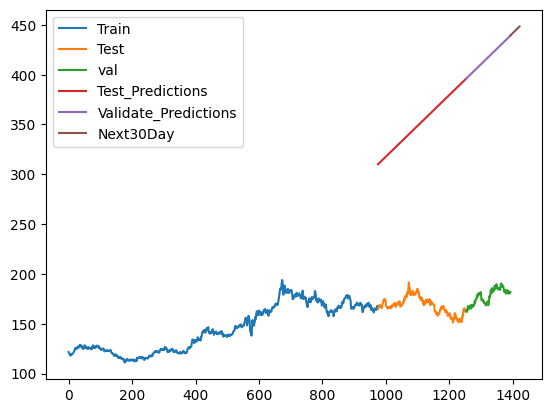

In [20]:
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(val_data.index, val_data['Close'])
plt.plot(test_data.index, y_pred_test)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data, y_pred_next)
plt.legend(['Train', 'Test','val', 'Test_Predictions','Validate_Predictions','Next30Day'])
plt.show()